# Project 15 - Age Verification

## Project Description

Good Seed, a supermarket chain, wants to know if Data Science can help them comply with the law by ensuring they do not sell age-restricted products to underage customers.

Steps of Task :

- The stores are equipped with cameras in the checkout area that will display a signal when someone buys an age-restricted product
- Computer vision methods can be used to determine a person's age from photos
- The next task is to build and evaluate a model to verify a person's age

### Data Description
*Dataset* will be save in `/datasets/faces/`and contain folder `final_file` with 7600 photos
- *File* `labels.csv` with 2 columns: `file_name` dan `real_age` 

Regarding the large number of pictures, the generator will be made with ImageDataGenerator

### Contents of Project:
1. Initialization
2. Data Overview
3. Explorative Data Analysis
4. Modelling
5. Model Training in GPU
6. Summary and Conclusion

## Initialization

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('default')

## Data Overview

In [3]:
# data directory
#data_root = '/datasets/faces/'

# data location
labels = pd.read_csv('labels.csv')

In [5]:
# labels information
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
# data description (statisctical)
labels.describe()

real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

**Findings :**
- There is no missing or anomaly value
- The avarage age of this project is 29, while the least number is 1 year old and the highest number is 100

## Explorative Data Analysis

In [6]:
# distinct age values with 0 for missing ages

df1 = labels['real_age'].value_counts().sort_index().reindex(np.arange(0, 101)).fillna(0).astype('int')
df1

0        0
1      149
2       88
3       25
4      101
      ... 
96       2
97       1
98       0
99       0
100      1
Name: real_age, Length: 101, dtype: int64

In [7]:
# age group 

df2 = pd.cut(labels['real_age'], np.arange(0, 101, 5), right=False).value_counts().sort_index()
df2 

[0, 5)        363
[5, 10)       300
[10, 15)      356
[15, 20)      857
[20, 25)      924
[25, 30)     1151
[30, 35)      920
[35, 40)      644
[40, 45)      545
[45, 50)      395
[50, 55)      391
[55, 60)      224
[60, 65)      174
[65, 70)      105
[70, 75)       89
[75, 80)       41
[80, 85)       50
[85, 90)       28
[90, 95)       28
[95, 100)       5
Name: real_age, dtype: int64

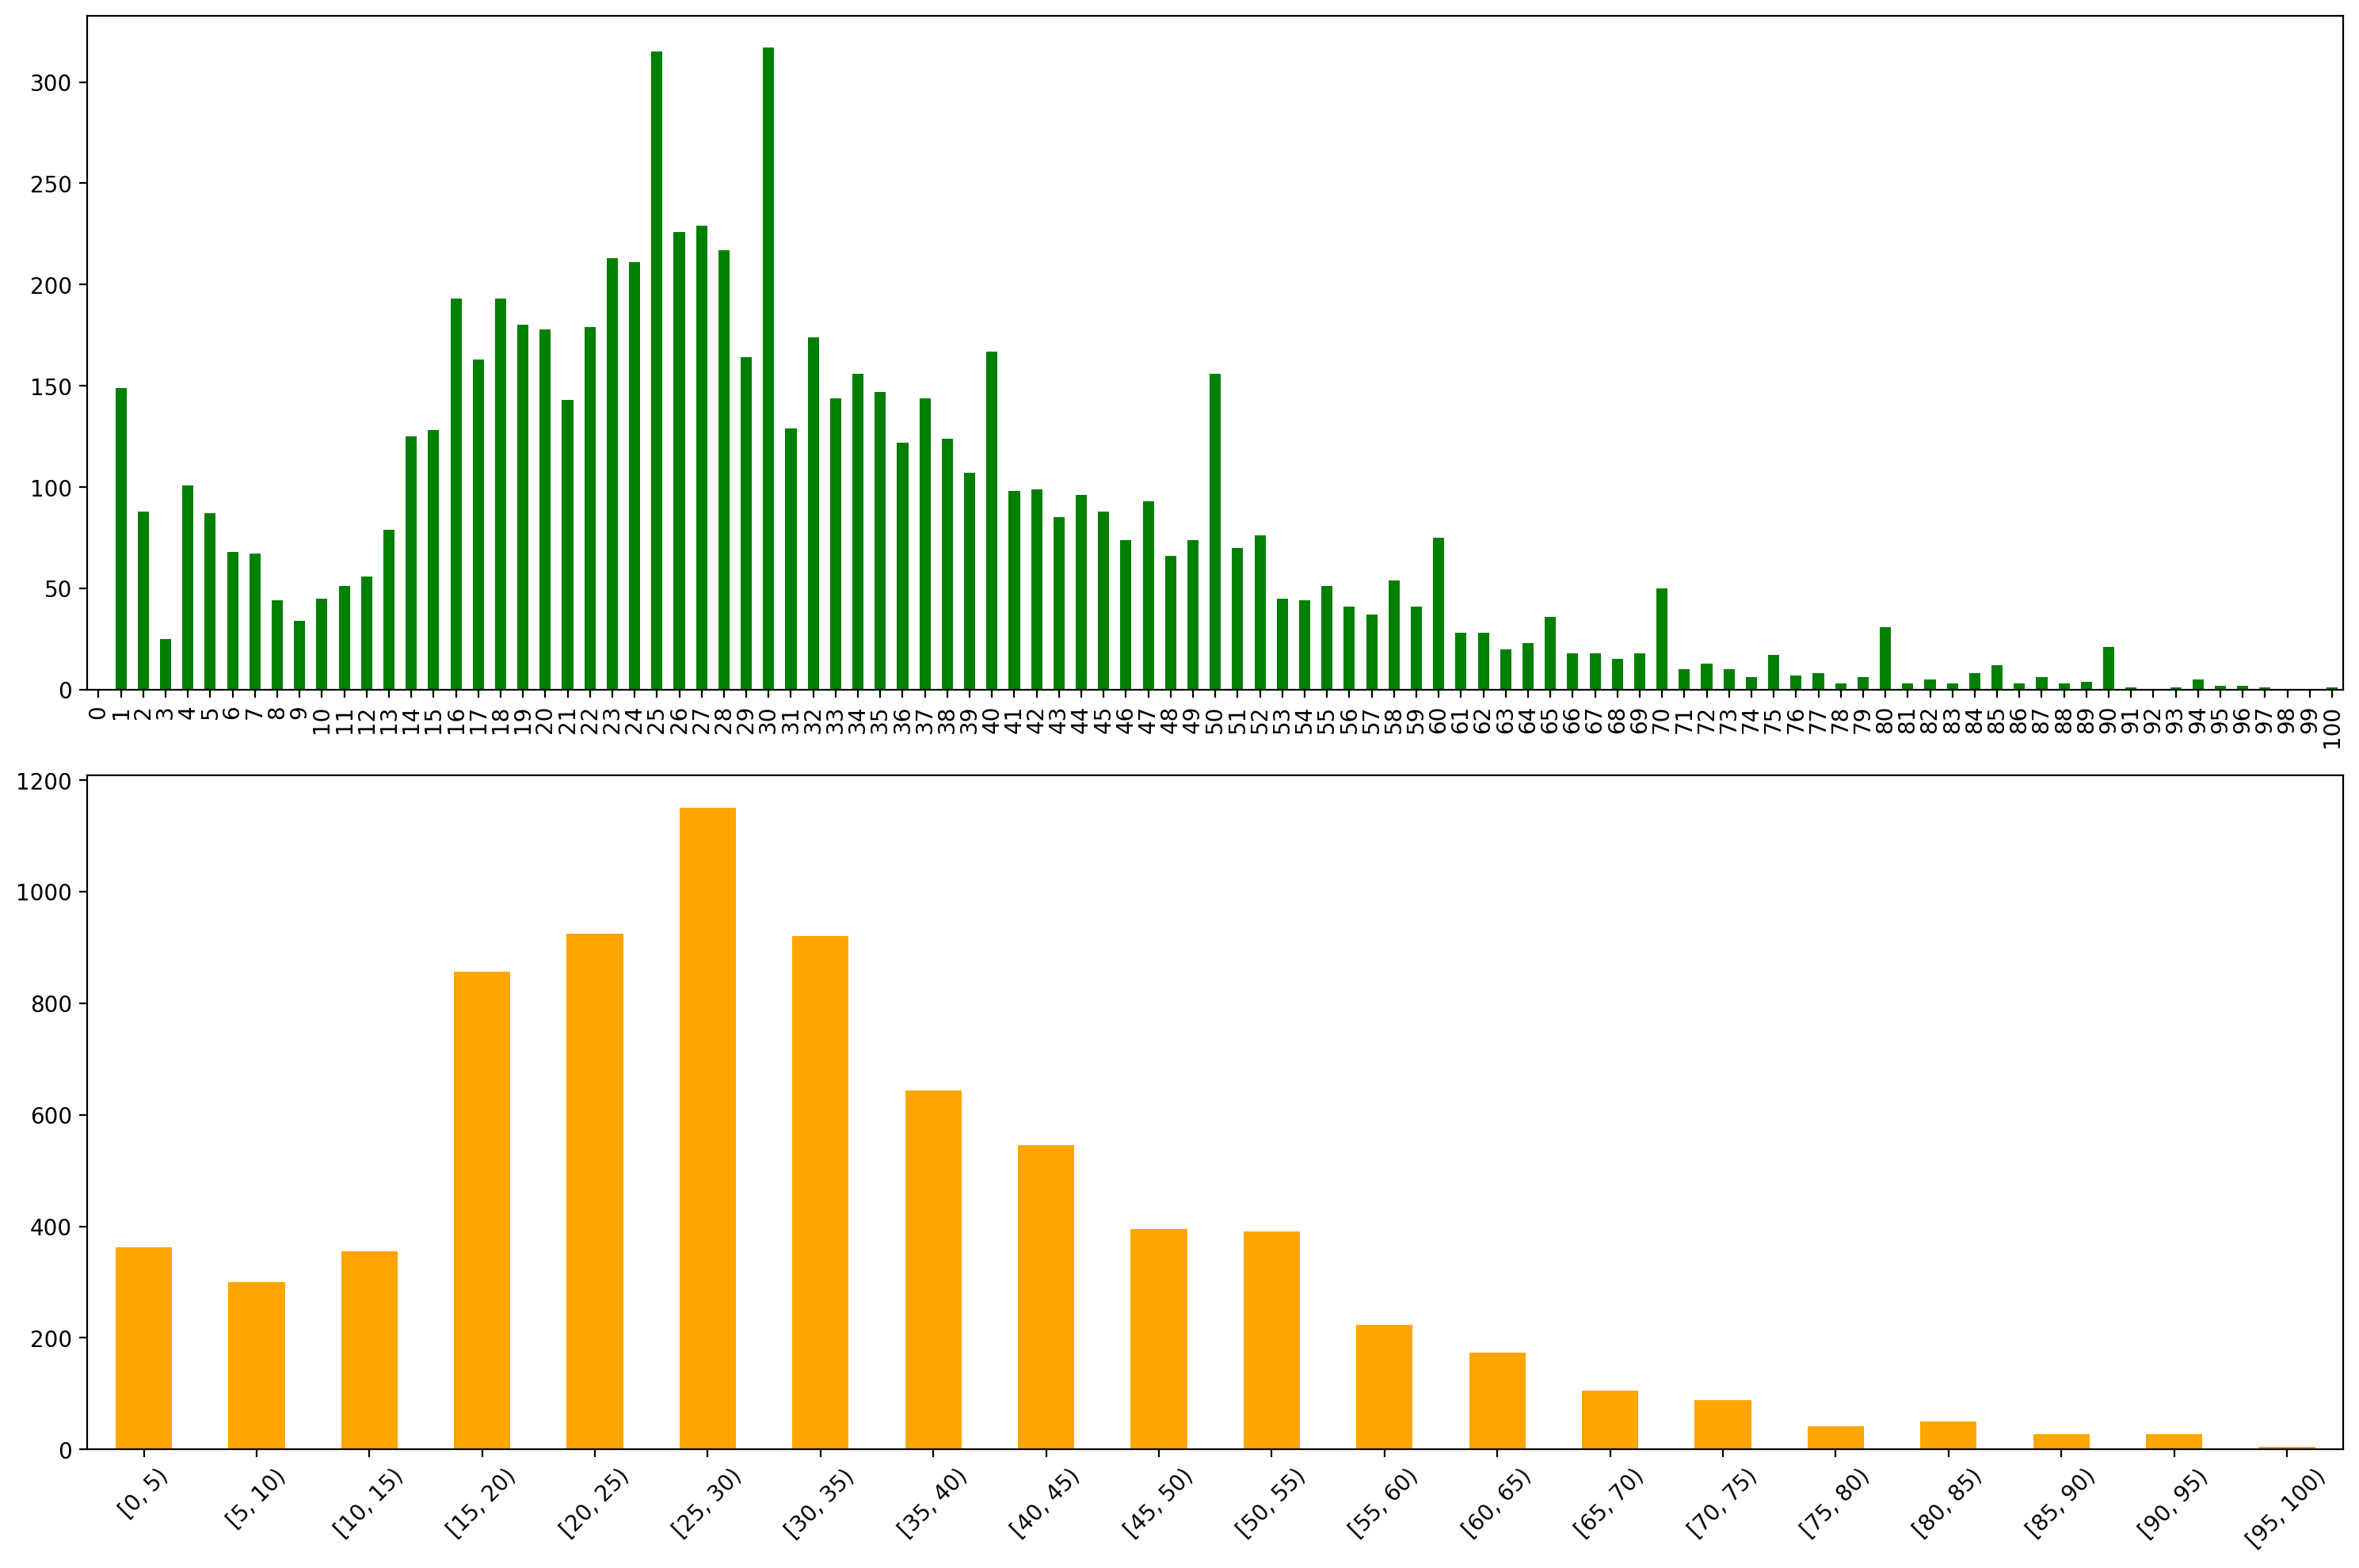

In [8]:
# data distribution


fig, axs = plt.subplots(2, 1, figsize=(15, 10))

ax = axs[0]
df1.plot(kind='bar', ax=ax, color='green')

ax = axs[1]
df2.plot(kind='bar', ax=ax, color='orange')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

fig.tight_layout()
plt.show()

**Findings :**
- There is a huge difference between young age(<18), middle age(18-60), and upper age(>60). It can generate quite big error while training the model
- For the age of more than 60 has the meast amount of pictures, it may be because of the few sources which focusing in those age
- The sample image will be shown to make sure those summary

### Sample Images

In [9]:
# function to load data and return to variable

def create_sample(min_age=0, max_age=100):
    
    datagen = ImageDataGenerator(rescale=1./255) # Set the pixel value in the range [0,1]
    
    gen_flow = datagen.flow_from_dataframe(
        dataframe=labels.query('real_age >= @min_age and real_age <= @max_age'),
        directory='/datasets/faces/final_files',
        x_col='file_name', 
        y_col='real_age',
        target_size=(240, 240),
        batch_size=16, 
        class_mode='raw',
        seed=12345)
    
    return gen_flow

In [10]:
# function for sample images

def sample_labels(batch, predictions=None):
    
    rows = 3
    cols = 5
    fig, axs = plt.subplots(rows, cols, figsize=(10, 6))

    for i in range(15):
        
        # fig.add_subplot(3, 5, i+1)
        row = i // cols
        col = i % cols
        ax = axs[row][col]
        ax.imshow(batch[0][i])
        real_age = batch[1][i]
        if predictions is None:
            title = f'age: {real_age}'
        else:
            title = f'age: {real_age}, pred: {round(predictions[i])}'
        ax.set_title(title, fontsize='medium')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    fig.tight_layout()

In [11]:
# insert the function into the variable

sample_0_16 = create_sample(min_age=0, max_age=16)
sample_17_65 = create_sample(min_age=17, max_age=65)
sample_66_100 = create_sample(min_age=66, max_age=100)

Found 1340 validated image filenames.
Found 5940 validated image filenames.
Found 311 validated image filenames.


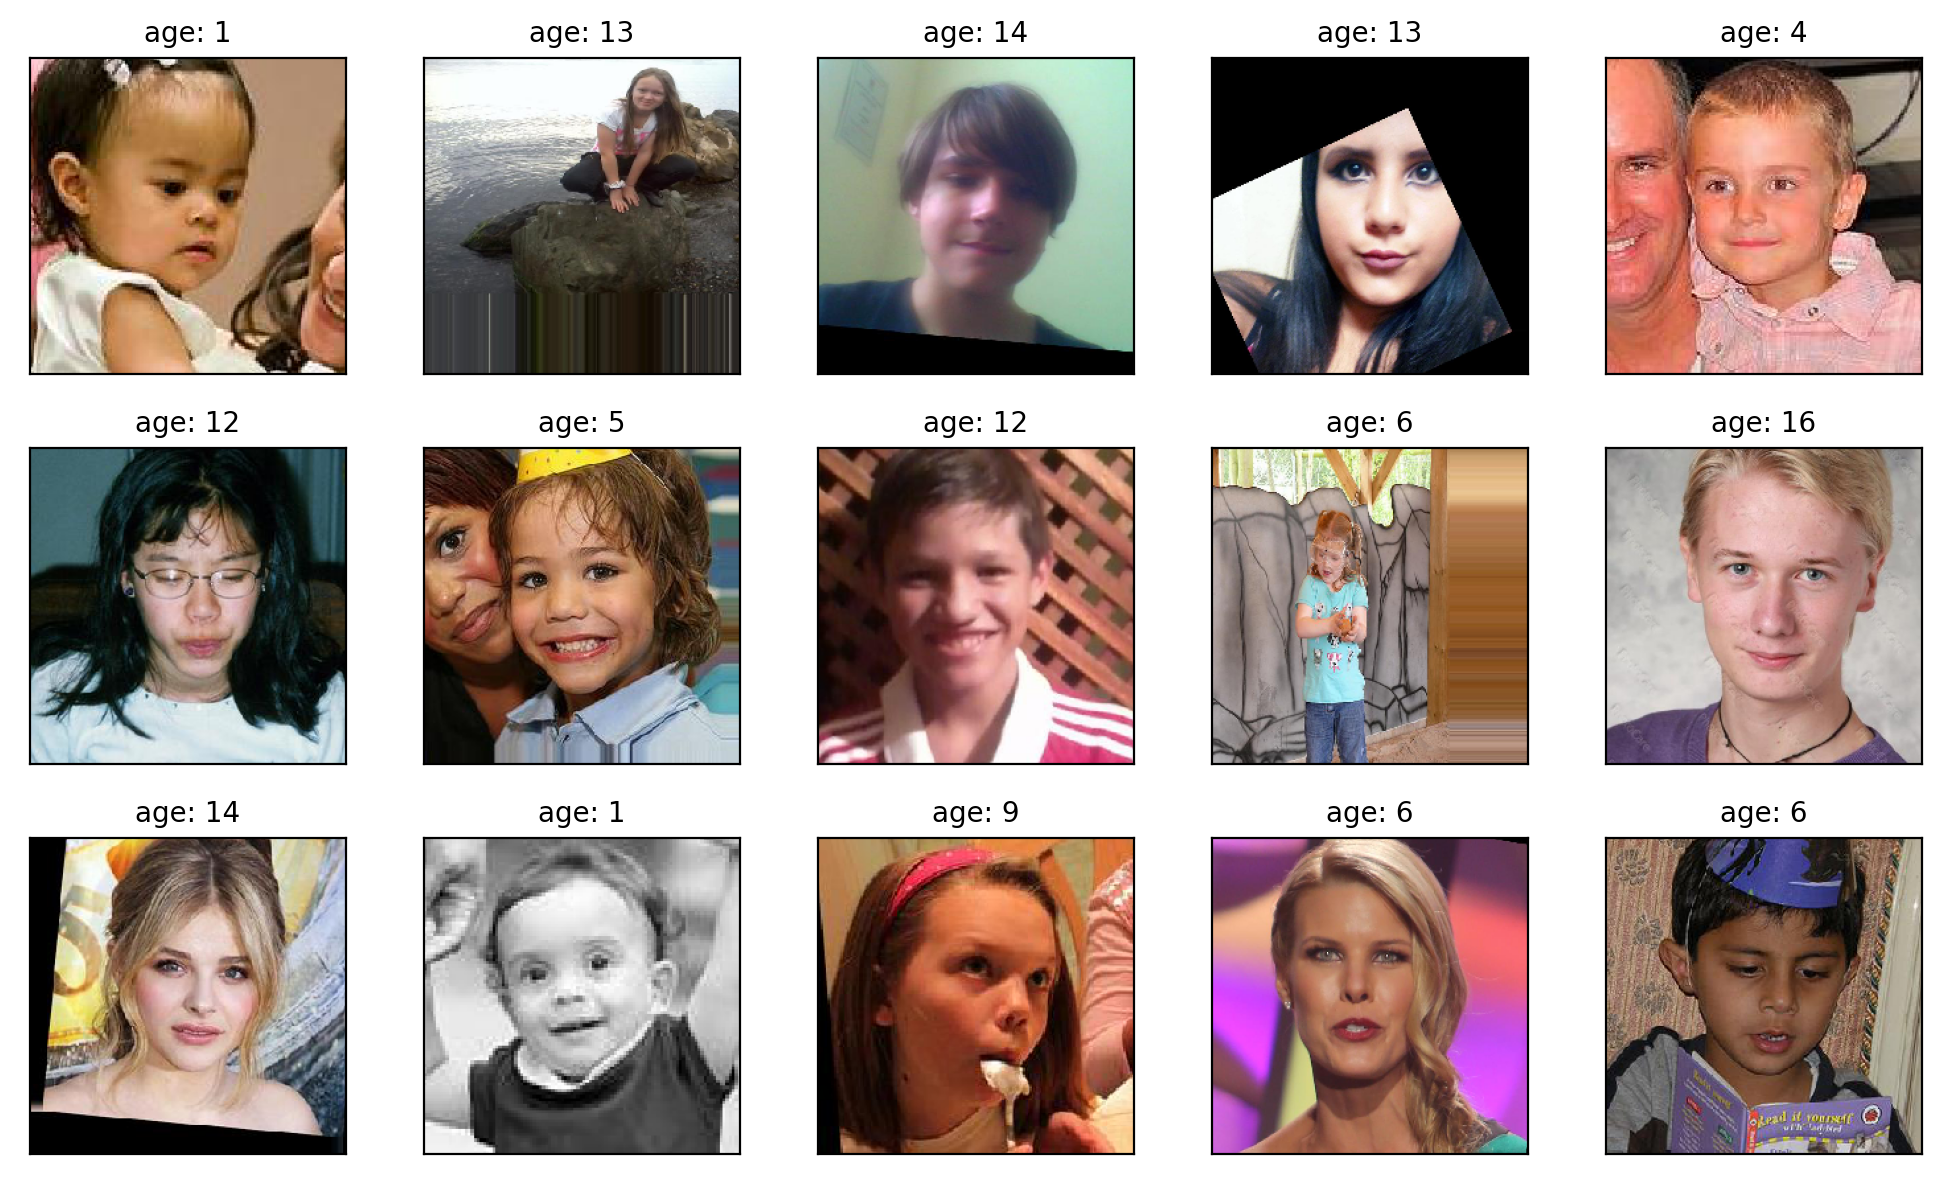

In [12]:
sample_labels(next(sample_0_16))

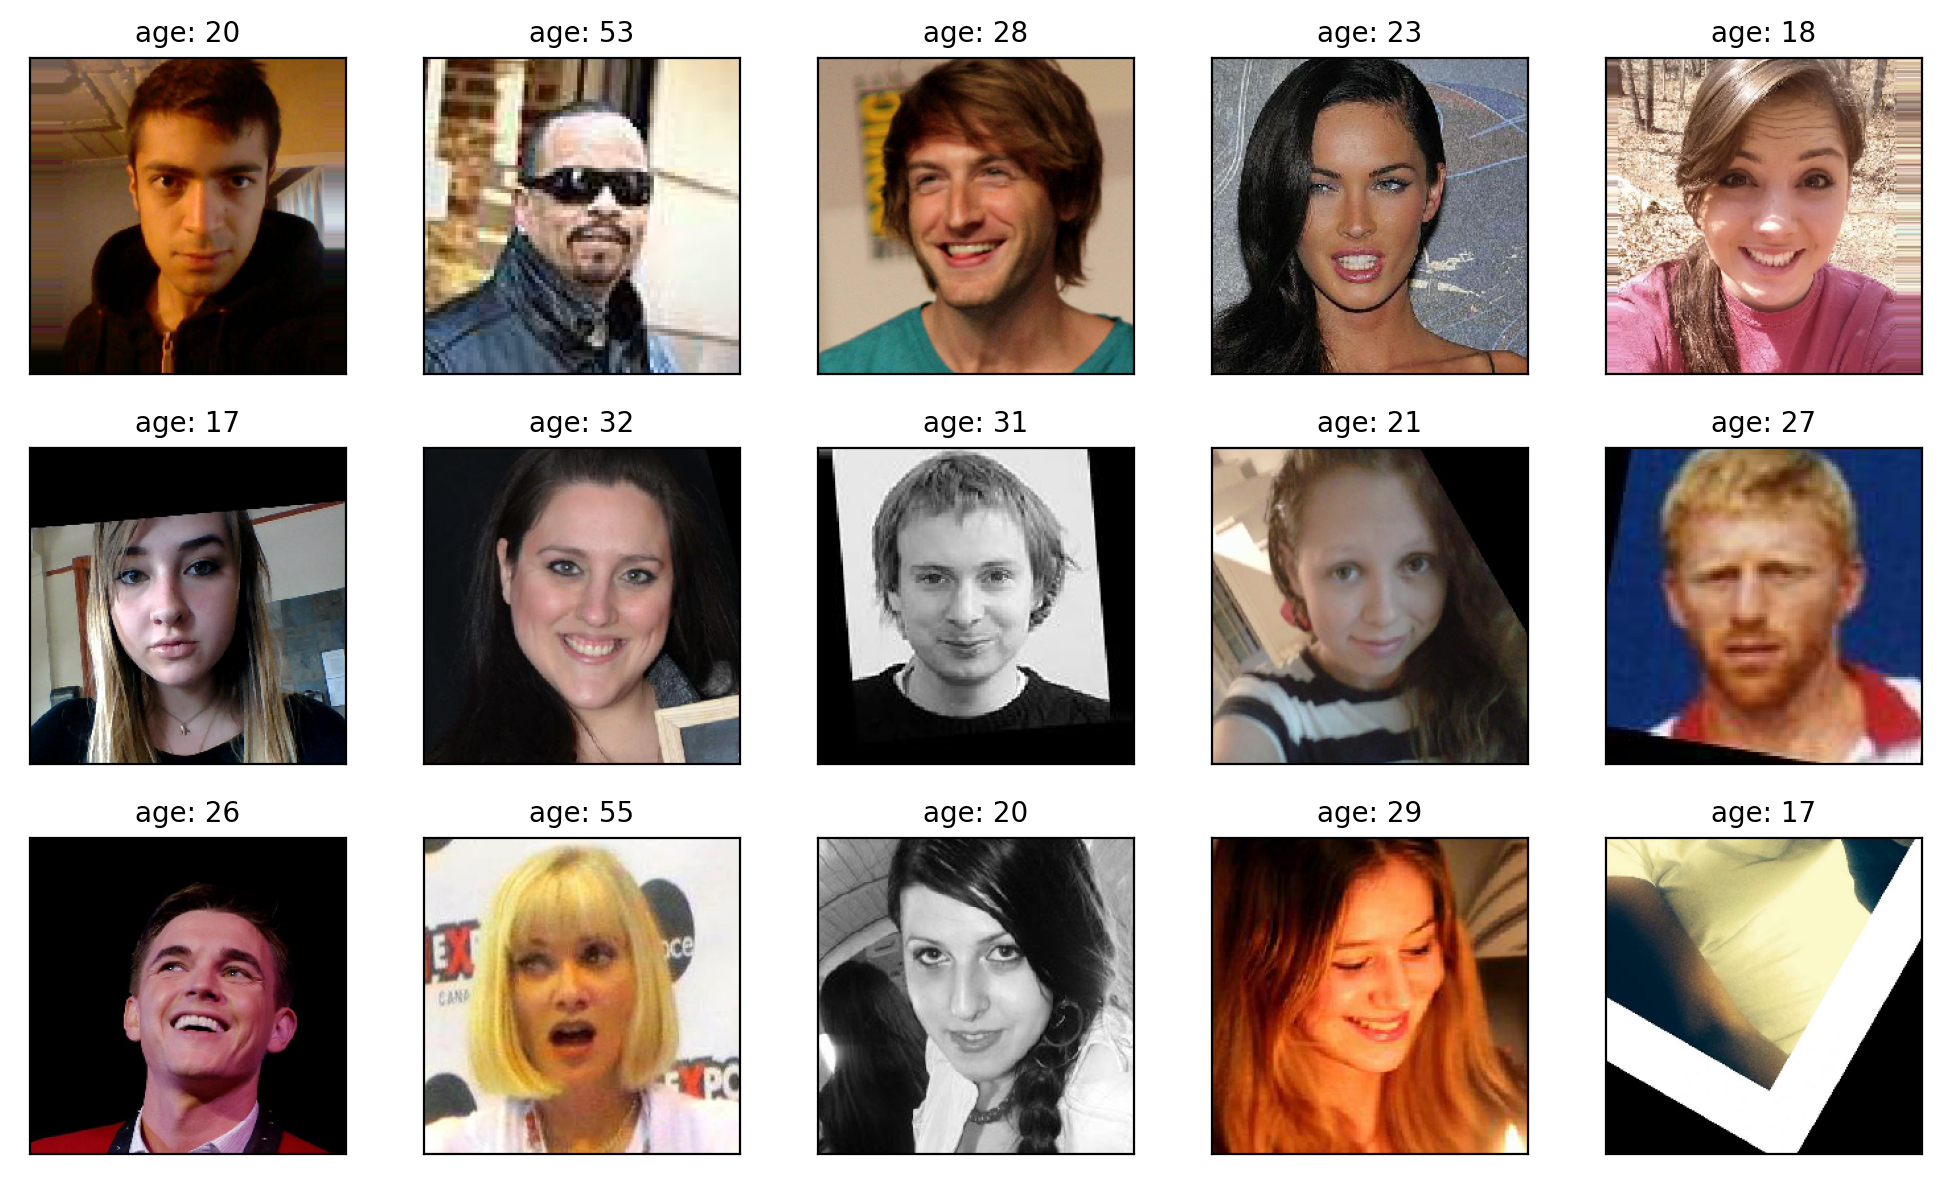

In [13]:
sample_labels(next(sample_17_65))

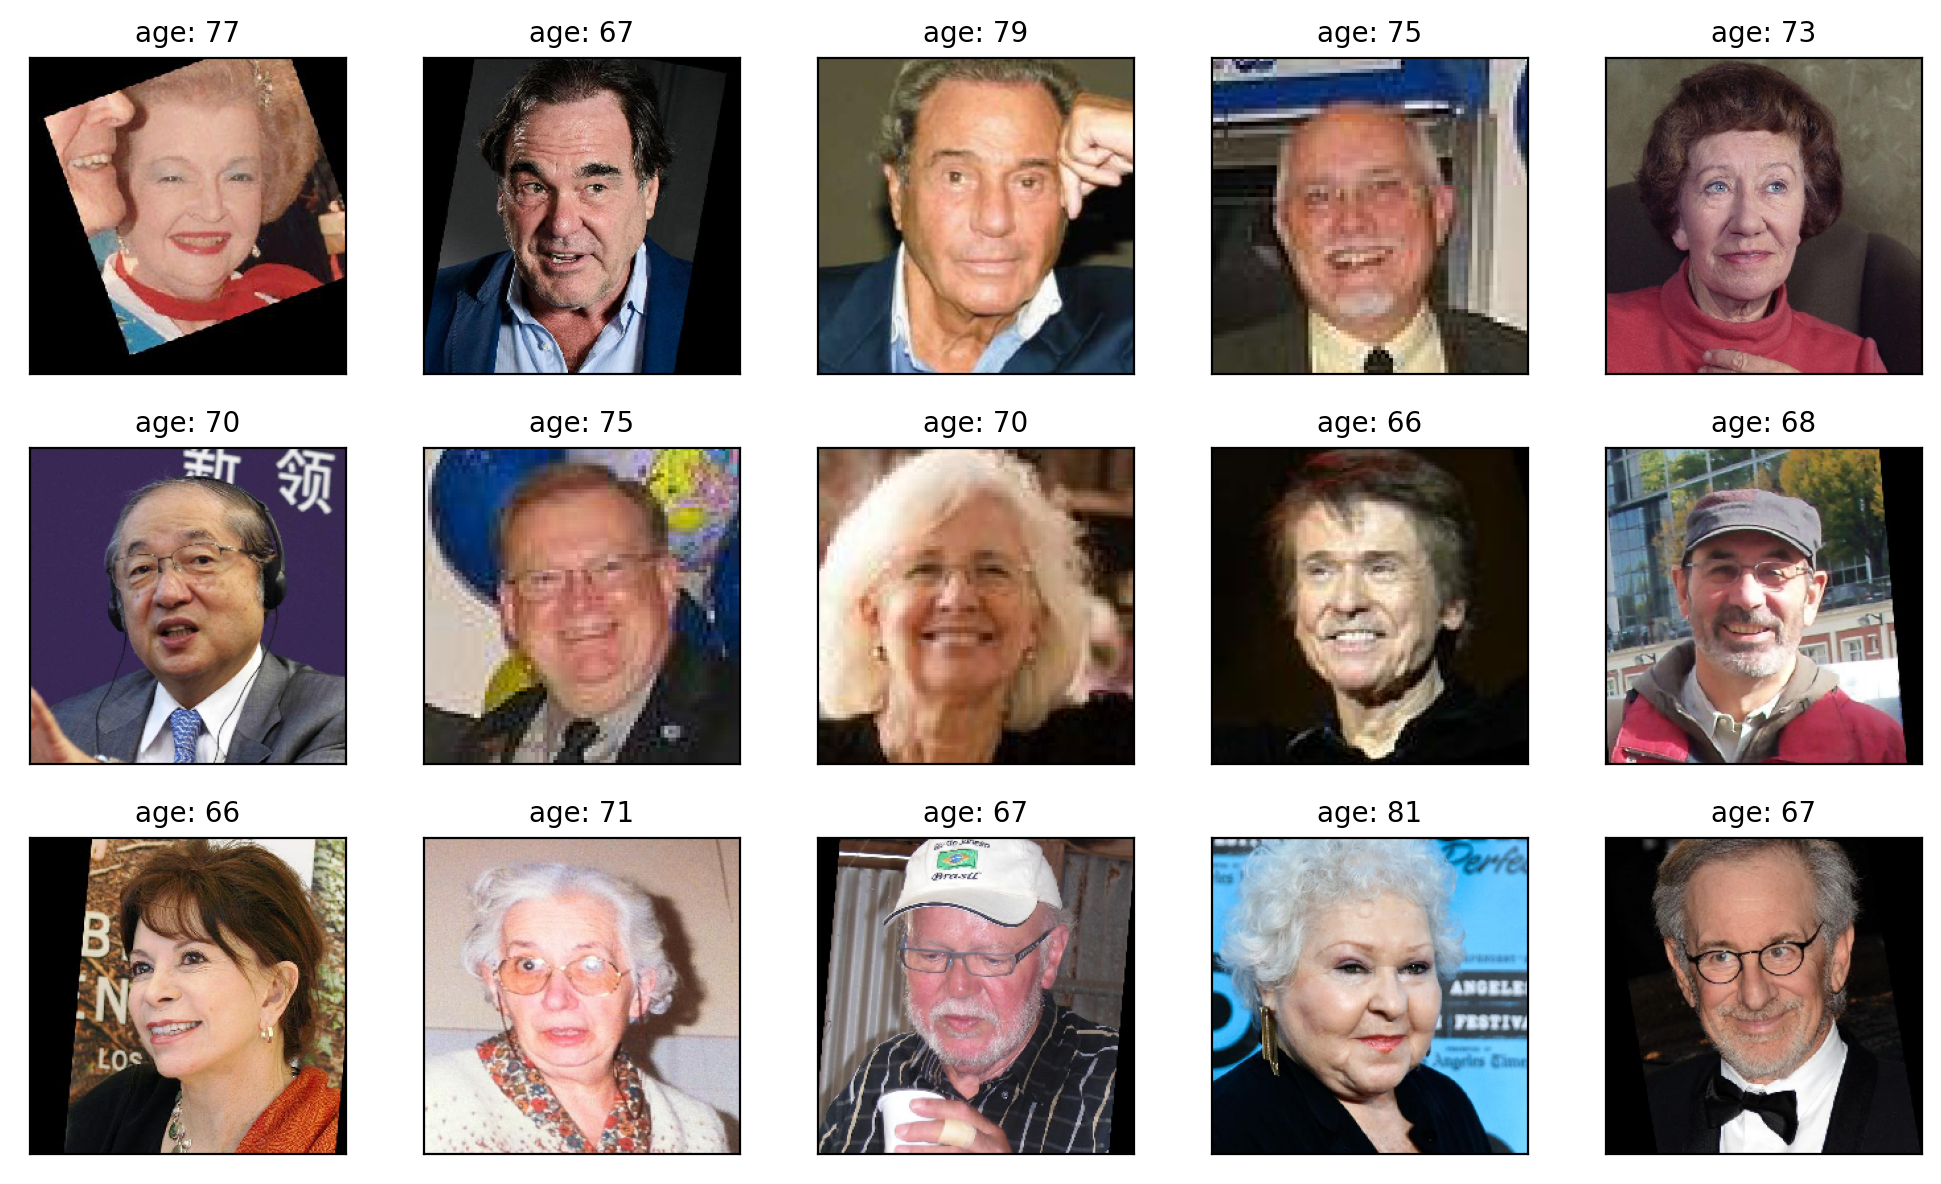

In [14]:
sample_labels(next(sample_66_100))

**Findings :**
- There are a lot of shape for the pictures, such as black and white, cropped photo, blur photo, compressed photo and etc
- It is better to use parameter such as, horizontal or vertical flip, color shade and brightness enhancement (thos two conclude in standard set)

## Modelling 

In [15]:
def load_train(path):
    
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1/255, validation_split=0.25, horizontal_flip=True, vertical_flip=True)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)

    return train_datagen_flow

In [16]:
def load_test(path):
    
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1/255, validation_split=0.25)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return train_datagen_flow

In [17]:
def create_model(input_shape):
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    optimizer = Adam(lr=0.0001)
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(
        units=16, 
        activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(
        units=1, 
        activity_regularizer=regularizers.l2(0.01), 
        activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

In [25]:
def train_model(model, 
                train_data, 
                test_data, 
                batch_size=None, 
                epochs=10,
                steps_per_epoch=None, 
                validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

In [19]:
# model summary
model = create_model((150, 150, 3))

model.summary()

2023-07-31 14:15:22.659826: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 23,620,513
Trainable params: 23,567,393
Non-trainable params: 53,120
_______________________________________

**Finding :**
- It has no doubt that ResNet is the most efficient model to maintain the low error

## Script for training the model in GPU platform

In [26]:
# platform GPU


init_str = '''
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
'''

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

In [22]:
# load dataset

train_data = load_train('/datasets/faces/')
test_data = load_test('/datasets/faces/')
model = create_model((150, 150, 3))

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [ ]:
%%time 
# train the model

model = train_model(model, train_data, test_data)

2023-07-31 14:28:54.778327: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-07-31 14:28:54.779984: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-07-31 14:28:55.807807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-07-31 14:28:55.854868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.855056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-07-31 14:28:55.855092: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-31 14:28:55.855146: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-31 14:28:55.857267: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-07-31 14:28:55.857595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-07-31 14:28:55.859724: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-07-31 14:28:55.860950: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-07-31 14:28:55.861005: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-07-31 14:28:55.861082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.861298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.861473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-07-31 14:28:55.861751: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-07-31 14:28:55.868790: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2023-07-31 14:28:55.869439: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x50c7730 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-07-31 14:28:55.869466: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-07-31 14:28:55.956293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.956593: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x49d9fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-31 14:28:55.956617: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-07-31 14:28:55.956840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.957001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-07-31 14:28:55.957037: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-31 14:28:55.957049: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-31 14:28:55.957076: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-07-31 14:28:55.957091: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-07-31 14:28:55.957107: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-07-31 14:28:55.957121: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-07-31 14:28:55.957132: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-07-31 14:28:55.957190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.957364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.957488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-07-31 14:28:55.957519: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-31 14:28:56.222113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-07-31 14:28:56.222163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-07-31 14:28:56.222173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-07-31 14:28:56.222379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:56.222619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:56.222817: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-31 14:28:56.222856: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
 2465792/94765736 [..............................] - ETA: 1s
 7094272/94765736 [=>............................] - ETA: 1s
11231232/94765736 [==>...........................] - ETA: 1s
16302080/94765736 [====>.........................] - ETA: 0s
22282240/94765736 [======>.......................] - ETA: 0s
28827648/94765736 [========>.....................] - ETA: 0s
36732928/94765736 [==========>...................] - ETA: 0s
45498368/94765736 [=============>................] - ETA: 0s
53665792/94765736 [===============>..............] - ETA: 0s
63455232/94765736 [===================>..........] - ETA: 0s
72605696/94765736 [=====================>........] - ETA: 0s
82624512/94765736 [=========================>....] - ETA: 0s
93601792/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-07-31 14:29:07.478080: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-31 14:29:07.708358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 294.6850 - mae: 12.4457 - val_loss: 831.2947 - val_mae: 23.8231
Epoch 2/10
178/178 - 38s - loss: 141.7294 - mae: 8.5831 - val_loss: 646.3885 - val_mae: 20.2121
Epoch 3/10
178/178 - 38s - loss: 116.2260 - mae: 7.6765 - val_loss: 365.6338 - val_mae: 14.0892
Epoch 4/10
178/178 - 37s - loss: 106.4202 - mae: 7.2845 - val_loss: 142.5016 - val_mae: 8.7196
Epoch 5/10
178/178 - 37s - loss: 99.3381 - mae: 7.0194 - val_loss: 90.5364 - val_mae: 6.6676
Epoch 6/10
178/178 - 37s - loss: 87.4884 - mae: 6.4920 - val_loss: 97.1581 - val_mae: 7.0826
Epoch 7/10
178/178 - 38s - loss: 82.7025 - mae: 6.2453 - val_loss: 80.8323 - val_mae: 6.3034
Epoch 8/10
178/178 - 37s - loss: 81.5275 - mae: 6.2053 - val_loss: 106.9229 - val_mae: 7.5091
Epoch 9/10
178/178 - 37s - loss: 76.2060 - mae: 5.9096 - val_loss: 86.6806 - val_mae: 6.4249
Epoch 10/10
178/178 - 38s - loss: 70.2678 - mae: 5.6747 - val_loss: 102.5844 - val_mae: 7.2055
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 102.5844 - mae: 7.2055
Test MAE: 7.2055
2023-07-31 14:28:54.778327: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2023-07-31 14:28:54.779984: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2023-07-31 14:28:55.807807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-07-31 14:28:55.854868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.855056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-07-31 14:28:55.855092: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-31 14:28:55.855146: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-31 14:28:55.857267: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-07-31 14:28:55.857595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-07-31 14:28:55.859724: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-07-31 14:28:55.860950: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-07-31 14:28:55.861005: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-07-31 14:28:55.861082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.861298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.861473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-07-31 14:28:55.861751: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-07-31 14:28:55.868790: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2023-07-31 14:28:55.869439: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x50c7730 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-07-31 14:28:55.869466: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-07-31 14:28:55.956293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.956593: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x49d9fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-31 14:28:55.956617: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2023-07-31 14:28:55.956840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.957001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-07-31 14:28:55.957037: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-31 14:28:55.957049: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-31 14:28:55.957076: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-07-31 14:28:55.957091: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-07-31 14:28:55.957107: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2023-07-31 14:28:55.957121: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2023-07-31 14:28:55.957132: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-07-31 14:28:55.957190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.957364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:55.957488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2023-07-31 14:28:55.957519: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-31 14:28:56.222113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-07-31 14:28:56.222163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2023-07-31 14:28:56.222173: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2023-07-31 14:28:56.222379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:56.222619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-31 14:28:56.222817: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-31 14:28:56.222856: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
 2465792/94765736 [..............................] - ETA: 1s
 7094272/94765736 [=>............................] - ETA: 1s
11231232/94765736 [==>...........................] - ETA: 1s
16302080/94765736 [====>.........................] - ETA: 0s
22282240/94765736 [======>.......................] - ETA: 0s
28827648/94765736 [========>.....................] - ETA: 0s
36732928/94765736 [==========>...................] - ETA: 0s
45498368/94765736 [=============>................] - ETA: 0s
53665792/94765736 [===============>..............] - ETA: 0s
63455232/94765736 [===================>..........] - ETA: 0s
72605696/94765736 [=====================>........] - ETA: 0s
82624512/94765736 [=========================>....] - ETA: 0s
93601792/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
- Epoch 1/10
2023-07-31 14:29:07.478080: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-31 14:29:07.708358: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 294.6850 - mae: 12.4457 - val_loss: 831.2947 - val_mae: 23.8231
- Epoch 2/10
178/178 - 38s - loss: 141.7294 - mae: 8.5831 - val_loss: 646.3885 - val_mae: 20.2121
- Epoch 3/10
178/178 - 38s - loss: 116.2260 - mae: 7.6765 - val_loss: 365.6338 - val_mae: 14.0892
- Epoch 4/10
178/178 - 37s - loss: 106.4202 - mae: 7.2845 - val_loss: 142.5016 - val_mae: 8.7196
- Epoch 5/10
178/178 - 37s - loss: 99.3381 - mae: 7.0194 - val_loss: 90.5364 - val_mae: 6.6676
- Epoch 6/10
178/178 - 37s - loss: 87.4884 - mae: 6.4920 - val_loss: 97.1581 - val_mae: 7.0826
- Epoch 7/10
178/178 - 38s - loss: 82.7025 - mae: 6.2453 - val_loss: 80.8323 - val_mae: 6.3034
- Epoch 8/10
178/178 - 37s - loss: 81.5275 - mae: 6.2053 - val_loss: 106.9229 - val_mae: 7.5091
- Epoch 9/10
178/178 - 37s - loss: 76.2060 - mae: 5.9096 - val_loss: 86.6806 - val_mae: 6.4249
- Epoch 10/10
178/178 - 38s - loss: 70.2678 - mae: 5.6747 - val_loss: 102.5844 - val_mae: 7.2055
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 102.5844 - mae: 7.2055
- **Test MAE: 7.2055**

## Summary

1. **Data Description**
- There is no missing or anomaly value from 7600 data of images
- The avarage age of this project is 29, while the least number is 1 year old and the highest number is 100

2. **EDA**
 - There is a huge difference between young age(<18), middle age(18-60), and upper age(>60). It can generate quite big error while training the model
 - For the age of more than 60 has the meast amount of pictures, it may be because of the few sources which focusing in those age
 - The sample image will be shown to make sure those summary
- Sample Images
 - There are a lot of shape for the pictures, such as black and white, cropped photo, blur photo, compressed photo and etc
 - It is better to use parameter such as, horizontal or vertical flip, color shade and brightness enhancement (thos two conclude in standard set)
 
3. **Modelling**
- It separate 75:25 for training set and test set
- It has no doubt that ResNet is the most efficient model to maintain the low error

## General Conclusion

- Excellent results were achieved from our model where our model avoided overfitting which has **MAE** at 7 with epochs=10
- The **adam** optimizer help to improve the result by lowering the training time
- With a lot of information and better quality of  the pictures, it is possible to make the **MAE** much lower
- The **ImageDataGenerator** also help to speed up the training process by reducing the image size